# Model spectra and synthetic photometry

In this tutorial, we will have a look at a synthetic spectrum from the [Sonora Diamondback](https://ui.adsabs.harvard.edu/abs/2024ApJ...975...59M) atmospheric model. The spectra are first downloaded and added to the database. Then we will use the functionalities of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) to extract a spectrum and calculate a photometric flux.

## Getting started

We start by importing the required classes and functions from `species`.

In [1]:
from species import SpeciesInit
from species.data.database import Database
from species.read.read_model import ReadModel
from species.plot.plot_spectrum import plot_spectrum

Then we initialize `species` with [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit), which creates a default configuration file and the HDF5 database.

In [2]:
SpeciesInit()

species

Version: 0.9.1.dev62+ge110897.d20250410
Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


## Adding model spectra to the database

To store the spectra, we first create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [3]:
database = Database()

Let's check which atmospheric models are available by running the [available_models](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.available_models) method of the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object.

In [4]:
_ = database.available_models()


-----------------------
Available model spectra
-----------------------

   - AMES-Cond:
      - Label = ames-cond
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [100, 6600]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 2000
      - File size: 57 MB

   - AMES-Dusty:
      - Label = ames-dusty
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [500, 4000]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 2000
      - File size: 22 MB

   - ATMO:
      - Label = atmo
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavelength range (um): [0.2, 2000]
      - Sampling (lambda/d_lambda): 1000
      - File size: 21 MB
      - Reference: Phillips et al. (2020)
      - URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P

   - ATMO CEQ:
      - Label = atmo-ceq
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavelen

Next, we will import the model spectra with the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This step will automatically download the [Sonora Diamondback](https://zenodo.org/records/12735103) spectra ($\lambda/\Delta\lambda = 6000$) to the [data_folder](https://species.readthedocs.io/en/latest/configuration.html). The data are then unpacked and added to the database. We restrict the temperature range to 1300-1700 K, so not all spectra are unpacked and added to the databse.

In [5]:
database.add_model(model='sonora-diamondback', teff_range=(1300., 1700.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: sonora-diamondback
Model name: Sonora Diamondback



100%|████████████████████████████████████████| 726M/726M [00:00<00:00, 363GB/s]



Unpacking 375/1200 model spectra from Sonora Diamondback (639 MB)... [DONE]

Please cite Morley et al. (2024) when using Sonora Diamondback in a publication
Reference URL: https://zenodo.org/records/12735103

Wavelength range (um) = 0.3 - 250
Sampling (lambda/d_lambda) = 6000
Teff range (K) = 1300.0 - 1700.0

Adding Sonora Diamondback model spectra... data/sonora-diamondback/sonora-diamondback_teff_1700_logg_5.5_feh_0.5_fsed_8_spec.npy 

Grid points stored in the database:
   - Teff = [1300. 1400. 1500. 1600. 1700.]
   - log(g) = [3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.5  0.   0.5]
   - f_sed = [1. 2. 3. 4. 8.]

Number of grid points per parameter:
   - teff: 5
   - logg: 5
   - feh: 3
   - fsed: 5

Number of stored grid points: 375
Number of interpolated grid points: 0
Number of missing grid points: 0


## Interpolating the model grid

We will now read the spectra from the database by creating an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel).

In [6]:
model = ReadModel(model='sonora-diamondback', wavel_range=(0.5, 10.))

Let's see what the grid boundaries are of the model grid that we stored in the database.

In [7]:
model.get_bounds()

{'teff': (np.float64(1300.0), np.float64(1700.0)),
 'logg': (np.float64(3.5), np.float64(5.5)),
 'feh': (np.float64(-0.5), np.float64(0.5)),
 'fsed': (np.float64(1.0), np.float64(8.0))}

We will now interpolate the grid in the ($T_\mathrm{eff}$, $\log(g)$, $[\mathrm{Fe}/\mathrm{H}]$, $f_\mathrm{sed}$) space by providing the parameters in a dictionary. The radius and distance (or parallax) are optional, otherwise the emitted flux is given at the planet surface.

In [8]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'fsed': 2.5, 'radius': 1., 'distance': 100.}

To interpolate a spectrum, we use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and provide the parameter dictionary as input, and we also set the optional resolving power, `spec_res`, such that the spectrum will be smoothed to this provided instrument resolution.

In [9]:
model_box = model.get_model(model_param=model_param, spec_res=200.)

The returned data are stored in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox). Let's have a look at its content!

In [10]:
model_box.open_box()

Opening ModelBox...
model = sonora-diamondback
type = None
wavelength = [ 0.49850832  0.49859061  0.49867291 ... 10.02768223 10.02933755
 10.03099315]
flux = [3.18634948e-19 3.18562800e-19 3.18394012e-19 ... 1.09300526e-18
 1.09339313e-18 1.09381960e-18]
parameters = {'teff': 1510.0, 'logg': 4.1, 'feh': 0.1, 'fsed': 2.5, 'radius': 1.0, 'distance': 100.0, 'log_lum_atm': np.float64(-4.30572764588594), 'log_lum': np.float64(-4.30572764588594), 'mass': np.float64(5.079072973539381)}
quantity = flux
contribution = None
bol_flux = None
spec_res = 200.0
extra_out = None


We will now create a new dictionary with the same atmospheric parameters, but we will also include the visual extinction, $A_V$, and use the extinction relation from [Gordon et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023ApJ...950...86G) through the [dust-extinction](https://dust-extinction.readthedocs.io) package.

In [11]:
param_ext = model_param.copy()
param_ext['ext_model'] = 'G23'
param_ext['ext_av'] = 5.0
print(param_ext)

{'teff': 1510.0, 'logg': 4.1, 'feh': 0.1, 'fsed': 2.5, 'radius': 1.0, 'distance': 100.0, 'log_lum_atm': np.float64(-4.30572764588594), 'log_lum': np.float64(-4.30572764588594), 'mass': np.float64(5.079072973539381), 'ext_model': 'G23', 'ext_av': 5.0}


We use again the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and store the result in another [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [12]:
model_ext = model.get_model(model_param=param_ext, spec_res=200.)

The two boxes with the model spectra are now provided as input to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function. We also include the filter profiles of several common filters.


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}


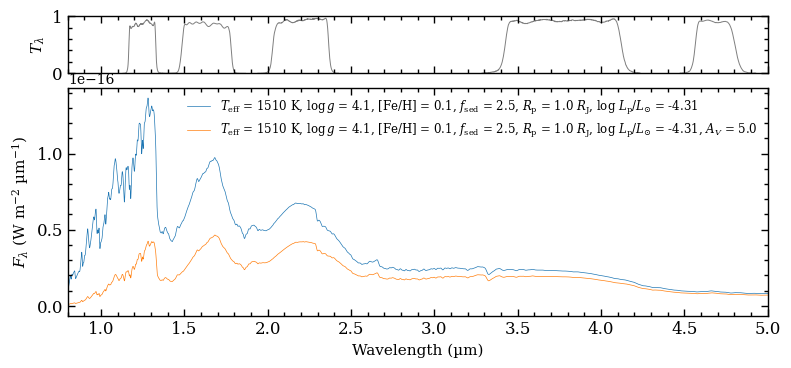

In [13]:
fig = plot_spectrum(boxes=[model_box, model_ext],
                    filters=['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp'],
                    xlim=(0.8, 5.),
                    legend={'loc': 'upper right', 'frameon': False, 'fontsize': 8.5},
                    figsize=(7., 3.),
                    output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [14]:
fig.axes

[<Axes: xlabel='Wavelength (µm)', ylabel='$F_\\lambda$ (W m$^{-2}$ µm$^{-1}$)'>,
 <Axes: ylabel='$T_\\lambda$'>]

## Extracting a spectrum at a grid point

It is also possible to extract a spectrum at one of the grid points, which doesn't require any interpolation. Let's check with the [get_points](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_points) method what parameter values are stored in the database.

In [15]:
model.get_points()

{'teff': array([1300., 1400., 1500., 1600., 1700.]),
 'logg': array([3.5, 4. , 4.5, 5. , 5.5]),
 'feh': array([-0.5,  0. ,  0.5]),
 'fsed': array([1., 2., 3., 4., 8.])}

We create a dictionary with values at one of the grid points.

In [16]:
model_param = {'teff':1500., 'logg':4., 'feh':0., 'fsed': 2.}

And now use the [get_data](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_data) method to extract a spectrum.

In [17]:
model_full = model.get_data(model_param)

Let's make another plot with [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). In this case, the spectrum is shown without applying a smoothing, although the `spec_res` parameter can also be set in `get_data`.


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}


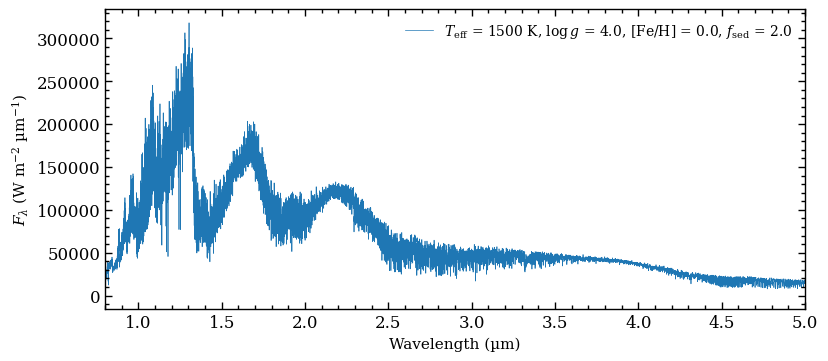

In [18]:
fig = plot_spectrum(boxes=[model_full],
                    filters=None,
                    xlim=(0.8, 5.),
                    legend={'loc': 'upper right', 'frameon': False, 'fontsize': 10.},
                    figsize=(7., 3.),
                    output=None)

## Calculating synthetic photometry

The [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) class can also be used for calculating photometric fluxes and magnitudes. To do so, we create a new instance and set the `filter_name` argument to the [VLT/NACO $M'$ filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/NACO.Mp&&mode=browse&gname=Paranal&gname2=NACO#filter). This will automatically download and add the filter profile. 

In [19]:
model = ReadModel(model='sonora-diamondback', filter_name='Paranal/NACO.Mp')

We create again a dictionary with the parameters but now run the [get_flux](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_flux) method, which returns the flux in W m$^{-2}$ $\mu$m$^{-1}$.

In [20]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'fsed': 2.5, 'radius': 1., 'distance': 100.}
flux = model.get_flux(model_param)
print(f'Flux (W m-2 um-1) = {flux[0]:.2e}')

100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 133MB/s]



Adding spectrum: Vega
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract
Flux (W m-2 um-1) = 8.74e-18


Since we provided a radius and distance, the emitted flux at the planet surface has been scaled by $(\mathrm{radius}/\mathrm{distance})^2$.

Similarly, we can use the [get_magnitude](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_magnitude) method to calculate the synthetic magnitude for the NACO $M'$ filter. Note that the returned absolute magnitude is set to `None` if the parameter dictionary does not contain a radius and distance.

In [21]:
app_mag, abs_mag = model.get_magnitude(model_param)
print(f'Apparent magnitude = {app_mag:.2f}')
print(f'Absolute magnitude = {abs_mag:.2f}')

Apparent magnitude = 15.96
Absolute magnitude = 10.96


As expected, at a distance of 100 pc, the difference between the apparent and absolute magnitude is 5.